In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from os.path import dirname, join
import numpy as np
#import click
#import snakemake
from src.utils.data_io import af_to_vireo
from icecream import ic


import seaborn as sns
import matplotlib.pyplot as plt

fig_utils from mplh


In [2]:
from src.utils import impute_af as imp

In [3]:
#cells_meta = "/mnt/md0/isshamie/Projects/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/cells_meta.tsv"
#sample = "Input,Flt3l"#["Input","Flt3l"]
# pileup_d = "/mnt/md0/isshamie/Projects/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_init/donor0"
# outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_prefilterMerge_impute/donor0"

cell_pct_cov_thresh = 0.6
cov_thresh = 10
alt_thresh = [{"cell_pct_cov_thresh":0.4, "cov_thresh": 10}, 
             {"cell_pct_cov_thresh":0.8, "cov_thresh": 10},
             {"cell_pct_cov_thresh":0.7, "cov_thresh": 30}, 
             {"cell_pct_cov_thresh":0.6, "cov_thresh": 30}]
ref_mt = "/data/Mito_Trace/data/external/chrM_refAllele.txt"



# pileup_d = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/coverage_merged/donor0"
# outdir="/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_prefilterMerge_impute/donor0"

pileup_d = "/data/Mito_Trace/output/pipeline/v04/CHIP_Input_nameFix_april08_2021/MTblacklist/data/coverage_merged/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/coverage_merged/donor3"
outdir = "/data/Mito_Trace/output/pipeline/v04/CHIP_Input_nameFix_april08_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_prefilterMerge_impute/donor3"

In [4]:
#sample = sample.split(",")

In [5]:
# cmd = f"cp {cells_meta} {join(outdir, 'cells_meta.tsv')}"
# print(cmd)
# !{cmd}


In [6]:
#cells_meta = pd.read_csv(cells_meta , sep='\t')
#sample = sample.split(',')
ref_fa = pd.read_csv(ref_mt, sep='\t', header=None, index_col=0)

In [7]:
af_pile = pd.read_csv(join(pileup_d, f"merged.af.tsv"), sep="\t", index_col=0).transpose()
dp_pile = pd.read_csv(join(pileup_d, f"merged.coverage.tsv"), sep="\t", index_col=0).transpose()

vars_map = {f"{x.split('>')[0][:-1]}{x[-1]}":x for x in af_pile.columns}
af_pile.columns = [f"{x.split('>')[0][:-1]}{x[-1]}" for x in af_pile.columns]
dp_pile.columns = [f"{x.split('>')[0][:-1]}{x[-1]}" for x in dp_pile.columns]
af_pile.index.name = "Cell"
dp_pile.index.name = "Cell"
#af_pile.columns.name = "Variant"


In [8]:
pileup_d

'/data/Mito_Trace/output/pipeline/v04/CHIP_Input_nameFix_april08_2021/MTblacklist/data/coverage_merged/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/coverage_merged/donor3'

In [9]:
af_pile

,2291T
Cell,
AAAGGATGTGCTGTGC-1_Flt3l,0.003868
AACAAAGTCTTACGGA-1_Flt3l,0.000000
AACCGATAGGTCGGTA-1_Flt3l,0.000000
AACGTACGTATTCGCA-1_Flt3l,0.000000
AATGGCTAGTGCAACG-1_Flt3l,0.000000
...,...
TGGGTTAGTGGACAGT-1_Flt3l,0.003795
TTAGGTGTCCATCTAT-1_Flt3l,0.005682
TTCAACTGTGCCGGTT-1_Flt3l,0.000000


## ?Find if it's the imputation.. dont i need to do that per donor? 

## Impute the new data:
### If coverage less than 10, and >80% have coverage, then impute the median of the cells with coverage onto the low coverage cells (do i need to set depth to 10?)

In [10]:
af_pile

,2291T
Cell,
AAAGGATGTGCTGTGC-1_Flt3l,0.003868
AACAAAGTCTTACGGA-1_Flt3l,0.000000
AACCGATAGGTCGGTA-1_Flt3l,0.000000
AACGTACGTATTCGCA-1_Flt3l,0.000000
AATGGCTAGTGCAACG-1_Flt3l,0.000000
...,...
TGGGTTAGTGGACAGT-1_Flt3l,0.003795
TTAGGTGTCCATCTAT-1_Flt3l,0.005682
TTCAACTGTGCCGGTT-1_Flt3l,0.000000


In [11]:
dp_pile

,2291T
Cell,
AAAGGATGTGCTGTGC-1_Flt3l,517
AACAAAGTCTTACGGA-1_Flt3l,403
AACCGATAGGTCGGTA-1_Flt3l,551
AACGTACGTATTCGCA-1_Flt3l,693
AATGGCTAGTGCAACG-1_Flt3l,779
...,...
TGGGTTAGTGGACAGT-1_Flt3l,527
TTAGGTGTCCATCTAT-1_Flt3l,704
TTCAACTGTGCCGGTT-1_Flt3l,526


In [12]:
imp_out = imp.impute_and_plot(af_pile, dp_pile, cov_thresh=cov_thresh, cell_pct_cov_thresh=cell_pct_cov_thresh,
                             include_orig=True)

#print(imp_out["imputed_indices"])
print(imp_out["median_d"])

before filt (88, 3)
after filt, low cov (0, 3)
imp_df shape (88, 1)
imp_df                              2291T
Cell                              
AAAGGATGTGCTGTGC-1_Flt3l  0.003868
AACAAAGTCTTACGGA-1_Flt3l  0.000000
AACCGATAGGTCGGTA-1_Flt3l  0.000000
AACGTACGTATTCGCA-1_Flt3l  0.000000
AATGGCTAGTGCAACG-1_Flt3l  0.000000
n vars imputed 0
{}


## Save output - af.tsv and dp.tsv

In [13]:
imp_out["impute_af"].to_csv(join(outdir, "af.tsv"), sep="\t")
dp_pile.loc[imp_out["impute_af"].index, imp_out["impute_af"].columns].to_csv(join(outdir, "dp.tsv"), sep="\t")

In [14]:
##  Create VireoIn

# Requires AD sparse matrix
af_df = imp_out["impute_af"].fillna(0)
dp_df = dp_pile.loc[imp_out["impute_af"].index, imp_out["impute_af"].columns].fillna(0)

## REMAP variant names 
# af_df.columns = [vars_map[x] for x in af_df.columns]
# dp_df.columns = [vars_map[x] for x in dp_df.columns]


af_to_vireo(af_df.transpose(), dp_df.transpose(),
            outdir=outdir,
            out_name="cellSNP")

curr_vars = af_df.columns

af_meta = pd.DataFrame({"POS": [int(x[:-1]) for x in curr_vars],
                                                "ALT": [x[-1] for x in curr_vars],
                                                "index": np.arange(1,len(curr_vars)+1),
                                                "REF": [f"{ref_fa.loc[int(x[:-1]),1]}{x[:-1]}" for x in curr_vars]
                                            }
                                        )
af_meta["#CHROM"] = "MT"
af_meta[["#CHROM", "POS", "REF","ALT", "index"]].to_csv(join(outdir, "cellSNP.base.vcf"),
               sep="\t", index=False)


cellSNP.tag


In [15]:
outdir

'/data/Mito_Trace/output/pipeline/v04/CHIP_Input_nameFix_april08_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/multiplex/clones_prefilterMerge_impute/donor3'

## plot with other parameters

In [16]:
for k in alt_thresh:
    curr_cell_pct_cov_thresh, curr_cov_thresh = k["cell_pct_cov_thresh"], k["cov_thresh"]
    curr_imp_out = imp.impute_and_plot(af_pile, dp_pile, 
                                       cov_thresh=curr_cov_thresh, cell_pct_cov_thresh=curr_cell_pct_cov_thresh,
                                       include_orig=False)    

before filt (88, 3)
after filt, low cov (0, 3)
imp_df shape (88, 1)
imp_df                              2291T
Cell                              
AAAGGATGTGCTGTGC-1_Flt3l  0.003868
AACAAAGTCTTACGGA-1_Flt3l  0.000000
AACCGATAGGTCGGTA-1_Flt3l  0.000000
AACGTACGTATTCGCA-1_Flt3l  0.000000
AATGGCTAGTGCAACG-1_Flt3l  0.000000
n vars imputed 0
before filt (88, 3)
after filt, low cov (0, 3)
imp_df shape (88, 1)
imp_df                              2291T
Cell                              
AAAGGATGTGCTGTGC-1_Flt3l  0.003868
AACAAAGTCTTACGGA-1_Flt3l  0.000000
AACCGATAGGTCGGTA-1_Flt3l  0.000000
AACGTACGTATTCGCA-1_Flt3l  0.000000
AATGGCTAGTGCAACG-1_Flt3l  0.000000
n vars imputed 0
before filt (88, 3)
after filt, low cov (0, 3)
imp_df shape (88, 1)
imp_df                              2291T
Cell                              
AAAGGATGTGCTGTGC-1_Flt3l  0.003868
AACAAAGTCTTACGGA-1_Flt3l  0.000000
AACCGATAGGTCGGTA-1_Flt3l  0.000000
AACGTACGTATTCGCA-1_Flt3l  0.000000
AATGGCTAGTGCAACG-1_Flt3l  0.000000
n vars

In [17]:
# cell_pct_cov_thresh = 0.4
# cov_thresh = 10
# imp_out = imp.impute_and_plot(af_pile, dp_pile, cov_thresh=cov_thresh, cell_pct_cov_thresh=cell_pct_cov_thresh,
#                              include_orig=True)

# #print(imp_out["imputed_indices"])
# print(imp_out["median_d"])

# cell_pct_cov_thresh = 0.8
# cov_thresh = 10
# imp_out = imp.impute_and_plot(af_pile, dp_pile, cov_thresh=cov_thresh, 
#                               cell_pct_cov_thresh=cell_pct_cov_thresh, include_orig=True)

# #print("number of variants imputed", len(imp_out["median_d"]))
# #print(imp_out["imputed_indices"])
# print(imp_out["median_d"])
# # diff_vars_impute = np.abs(imp_df-af_pile).sum().sort_values()[::-1]
# # print(diff_vars_impute)
# # if not (np.abs(imp_df-af_pile).sum().sort_values()[::-1].sum()==0):

# #     diff_vars_impute = diff_vars_impute.index
# #     _, g_pile = impute_and_plot(af_pile.loc[:, diff_vars_impute[:20]], 
# #                                 dp_pile.loc[:, diff_vars_impute[:20]], cov_thresh=cov_thresh, cell_pct_cov_thresh=cell_pct_cov_thresh)
# # else:
# #     print('no imputation done')

# cell_pct_cov_thresh = 0.7
# cov_thresh = 30
# imp_out = imp.impute_and_plot(af_pile, dp_pile, cov_thresh=cov_thresh, 
#                               cell_pct_cov_thresh=cell_pct_cov_thresh, include_orig=True)

# #print("number of variants imputed", len(imp_out["median_d"]))
# #print(imp_out["imputed_indices"])
# print(imp_out["median_d"])


# cell_pct_cov_thresh = 0.6
# cov_thresh = 30
# imp_out = imp.impute_and_plot(af_pile, dp_pile, cov_thresh=cov_thresh, 
#                               cell_pct_cov_thresh=cell_pct_cov_thresh, include_orig=True)

# #print("number of variants imputed", len(imp_out["median_d"]))
# #print(imp_out["imputed_indices"])
# print(imp_out["median_d"])



In [18]:
# from mplh import cluster_help as ch
# ch.plot_cluster(df=imp_out["impute_af"], 
#                 col_meta=pd.DataFrame(imp_out["median_d"], index=["median"]).transpose(),
#                 col_clr_schemes="sequential")

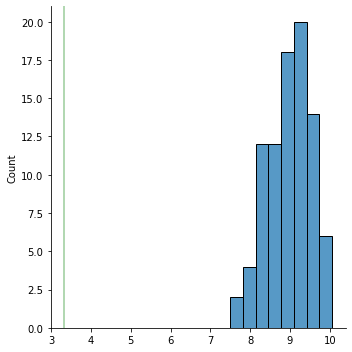

In [19]:
flat_dp = dp_pile.values.flatten()
flat_dp = flat_dp[flat_dp!=0]
sns.displot(np.log2(1+flat_dp))
#plt.gca().set_ylim([0, 400000])
plt.axvline(np.log2(10), color='green', alpha=0.4)